In [1]:
#install PyG in google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz

import numpy as np
import torch as th
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from pyg_classifier.data import CGDataset


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
num_neighbours = 0

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt"
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, num_neighbours)

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, num_neighbours)

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, num_neighbours)

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, num_neighbours)

Pytorch Version 1.10.2
Cuda is available: True
Using device: cuda


In [2]:
import torch_geometric.utils as pygu
import networkx as nx
print(training_dataset)
print(training_dataset[0])
print(training_dataset.data.x.shape)
print(training_dataset.data.is_undirected())
print(len(training_dataset))
print(training_dataset[1].num_nodes)
print(training_dataset[1].y)
#print(training_dataset[1].adj)
#print(pygu.to_dense_adj(training_dataset[0].edge_index))#to_scipy_sparse_matrix(training_dataset[0].edge_index))
#g = pygu.convert.to_networkx(training_dataset[1].adj,node_attrs=training_dataset[0].x, edge_attrs=None, to_undirected=True )
#nx.draw(g)
print(max([t.num_nodes for t in training_dataset]))


CGDataset(760)
Data(x=[12, 15], edge_index=[2, 24], y=[1], name='5jb3_4_tRNA_4_rn37.cg')
torch.Size([11769, 15])
True
760
12
tensor([15.9000])
22


TODO:
*  

In [3]:
#Model
import torch.nn.functional as F
import torch_geometric.nn as tgnn

#Coarse Grain RNA Classifier Model
class CG_Classifier(th.nn.Module):
    def __init__(self, num_node_feats):
        self.num_node_feats = num_node_feats
        self.c = 0
        super(CG_Classifier, self).__init__()
        
        self.conv1 = tgnn.TAGConv(self.num_node_feats, 200, K=2)
        self.conv2 = tgnn.TAGConv(200, 200, K=2)
        self.conv3 = tgnn.TAGConv(200, 200, K=2)
        self.conv4 = tgnn.TAGConv(200, 200, K=2)
        self.conv5 = tgnn.TAGConv(200, 50, K=2)

        self.sage_conv1 = tgnn.SAGEConv(50, 100)
        self.sage_conv2 = tgnn.SAGEConv(100, 100)
        self.sage_conv3 = tgnn.SAGEConv(100, 100)
        self.sage_conv4 = tgnn.SAGEConv(100, 100)
        self.sage_conv5 = tgnn.SAGEConv(100, 50)
        
        self.classify = th.nn.Sequential(
            th.nn.Linear(50, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 512),
            th.nn.ELU(),
            th.nn.Linear(512, 1)
        )

        self.pos = th.nn.ReLU()
        
    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = self.conv4(x, edge_index)
        x = F.elu(x)
        x = self.conv5(x, edge_index)
        x = F.elu(x)

        x = self.sage_conv1(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv2(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv3(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv4(x, edge_index)
        x = F.elu(x)
        x = self.sage_conv5(x, edge_index)
        x = F.elu(x)

        x = tgnn.global_mean_pool(x, batch) #self.readout(x, edge_index)
        
        x = self.classify(x)
        return self.pos(x)

Epoch 0: Training loss 9.8656, Validation loss 12.8116, learning rate: 0.00100
Epoch 5: Training loss 6.4120, Validation loss 12.7631, learning rate: 0.00100
Epoch 10: Training loss 4.2167, Validation loss 12.8423, learning rate: 0.00100
Epoch 15: Training loss 3.7115, Validation loss 13.0419, learning rate: 0.00100
Epoch 20: Training loss 3.2646, Validation loss 13.0179, learning rate: 0.00100
Epoch 25: Training loss 3.1128, Validation loss 13.2079, learning rate: 0.00099
Epoch 30: Training loss 2.4699, Validation loss 12.8324, learning rate: 0.00099
Epoch 35: Training loss 2.4111, Validation loss 12.8216, learning rate: 0.00099
Epoch 40: Training loss 2.4263, Validation loss 12.9534, learning rate: 0.00098
Epoch 45: Training loss 1.9475, Validation loss 13.0298, learning rate: 0.00098
Epoch 50: Training loss 1.8659, Validation loss 13.1726, learning rate: 0.00097
Epoch 55: Training loss 1.4185, Validation loss 13.0061, learning rate: 0.00097
Epoch 60: Training loss 1.6924, Validation

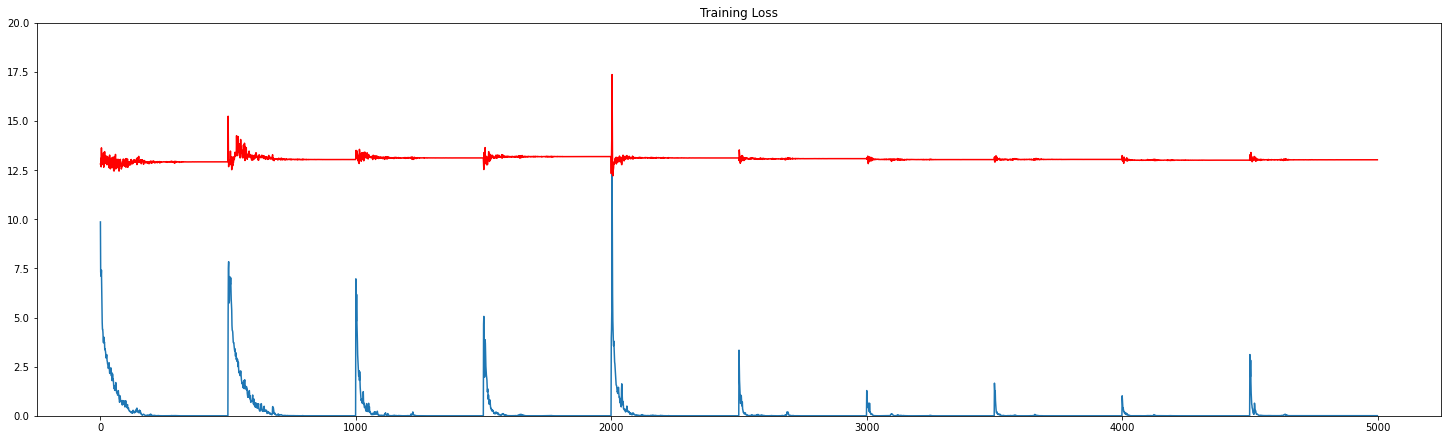

In [12]:
#Training
import time
start = time.perf_counter()

model = CG_Classifier(num_node_feats=training_dataset.num_node_features).to(device)

b_size = 64
train_dataloader = DataLoader(training_dataset, batch_size=b_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=b_size)

opt = th.optim.Adam(model.parameters(), lr=1e-3)
scheduler = th.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=500)#, T_mult=2)
model.train()

epochs = 5000

def training_loop(model, learning_rates, train_dataloader, scheduler, opt):
    model.train()
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred = model(data)
        loss = F.smooth_l1_loss(th.reshape(pred, (-1,)), data.y, reduction='mean')
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    return epoch_loss

@th.no_grad()
def val_loop(model, val_dataloader):
    model.eval()
    val_loss = 0
    for i, v_data in enumerate(val_dataloader):
        v_data = v_data.to(device)
        val_pred = model(v_data)
        v_loss = F.smooth_l1_loss(th.reshape(val_pred, (-1,)), v_data.y, reduction='mean')
        val_loss += v_loss.detach().item()

    val_loss /= (i + 1)
    return val_loss

#training setup
epoch_losses = []
val_losses = []
learning_rates = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred = model(data)
        loss = F.smooth_l1_loss(th.reshape(pred, (-1,)), data.y, reduction='mean')
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    #epoch_loss = training_loop(model, learning_rates, train_dataloader, scheduler, opt) #what to put into training_loop and what to return?
    epoch_losses.append(epoch_loss)

    val_loss = val_loop(model, val_dataloader)
    val_losses.append(val_loss)
    
    th.save(model.state_dict(), "pyg_model_data/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print("Epoch {}: Training loss {:.4f}, Validation loss {:.4f}, learning rate: {:.5f}".format(epoch, epoch_loss, val_loss, scheduler.get_last_lr()[0]))
        
end = time.perf_counter()

print("Training took {:.2f} hours".format((end - start)/60/60))
print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))

#plot the training run
figure, ax = plt.subplots(layout='constrained', figsize=(20, 6))
ax.plot(epoch_losses)
ax.plot(val_losses, 'r')
plt.title("Training Loss")
ax.set_ybound(lower=0, upper=20)
plt.draw()

In [13]:
#store training run data

file = "pyg_vector_loss_data_2022-03-07.txt"

with open("loss_data/" + file, "w") as fh:
    fh.write(str(epoch_losses) + "\n")
    fh.write(str(val_losses) + "\n")
    fh.write(str(learning_rates))

In [4]:
#get training run data

file = "pyg_vector_loss_data_2022-03-07.txt"

file_lines = []
with open("loss_data/" + file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]

print("Minimum Training Loss {:.4f} in epoch {}".format(min(epoch_losses), epoch_losses.index(min(epoch_losses))))
print("Minimum Validation Loss {:.4f} in epoch {}".format(min(val_losses), val_losses.index(min(val_losses))))


Minimum Training Loss 0.0000 in epoch 4494
Minimum Validation Loss 12.2110 in epoch 2006


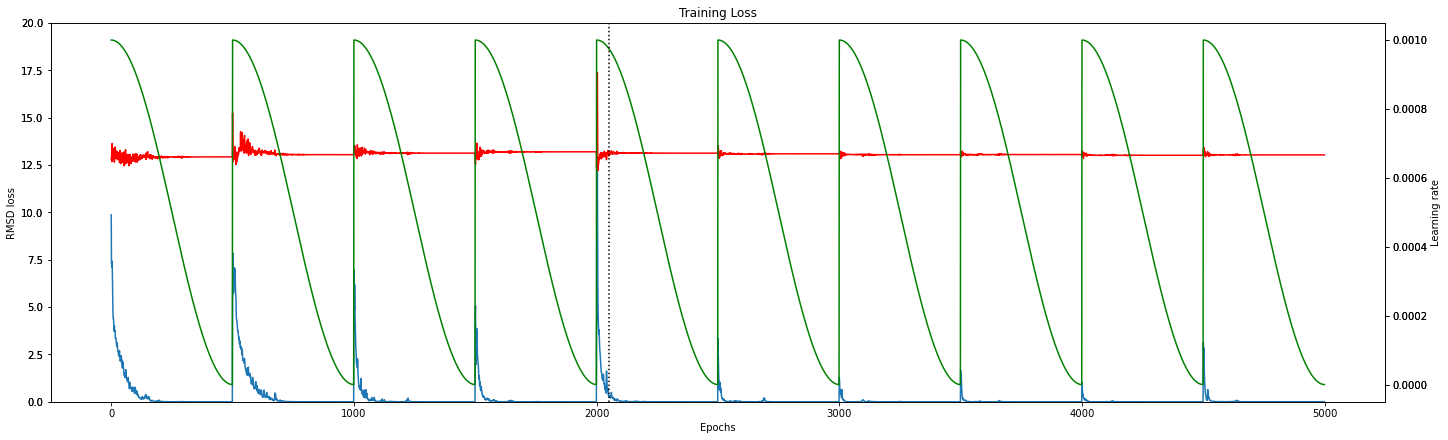

In [14]:
#plot the training run
fig, ax1 = plt.subplots(layout='constrained', figsize=(20, 6))
ax1.secondary_yaxis('left')
ax1.plot(epoch_losses)
ax1.plot(val_losses, 'r')
ax2 = ax1.twinx()
ax2.secondary_yaxis('right')
ax2.plot(learning_rates, 'g')
plt.title("Training Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("RMSD loss")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=20)
plt.axvline(x = 2050, c = 'black', ls = ':')
#plt.axvline(x = 96, c = 'black', ls = ':')
#plt.axvline(x = 145, c = 'black', ls = ':')
#plt.axvline(x = 190, c = 'black', ls = ':')
#plt.axvline(x = 250, c = 'black', ls = ':')
#plt.axvline(x = 321, c = 'black', ls = ':')
#plt.axvline(x = 404, c = 'black', ls = ':')
plt.draw()

In [6]:
#Test Loop
import math
from pyg_classifier.utility import loss_plot, rmsd_scatter, e_rmsd_scatter

@th.no_grad()
def test_loop(model, loader, e_dict, title):
    model.eval()
    max_label = 0
    max_loss = 0
    max_pred = 0
    min_label = math.inf
    min_loss = math.inf
    min_pred = math.inf
    test_losses = []
    true_rmsds = []
    pred_rmsds = []
    energies = []
    trmsds_f_en = []
    prmsds_f_en = []
    for test_graph in loader:
        test_graph = test_graph.to(device)
        test_pred = model(test_graph)
        test_loss = F.l1_loss(th.reshape(test_pred, (-1,)), test_graph.y).item() #smooth_l1_loss #(test_pred, test_graph.y).item() #
        test_losses.append(float(test_loss))
        true_rmsds.append(float(test_graph.y))
        pred_rmsds.append(float(test_pred))

        if test_graph.name[0] in e_dict.keys():
            energies.append(e_dict[test_graph.name[0]])
            prmsds_f_en.append(float(test_pred))
            trmsds_f_en.append(float(test_graph.y))
        if test_loss > max_loss:
            max_loss = test_loss
            max_label = test_graph.y
            max_pred = test_pred
        if test_loss < min_loss:
            min_loss = test_loss
            min_label = test_graph.y
            min_pred = test_pred
        if test_pred < 0:
            print(test_graph.y, test_pred)
    
    print(title)
    print(min_label, min_pred, min_loss)
    print(max_label, max_pred, max_loss)
    test_mean = np.mean(test_losses)
    test_std = np.std(test_losses)
    test_fq = np.quantile(test_losses, q = 0.25)
    test_median = np.median(test_losses)
    test_tq = np.quantile(test_losses, q = 0.75)
    print("Mean Test loss: \t {:.4f}".format(test_mean))
    print("Std. Dev. of Test loss:  {:.4f}".format(test_std))
    print("Min loss: \t\t {:.4f}".format(min(test_losses)))
    print("First Quantile: \t {:.4f}".format(test_fq))
    print("Median: \t\t {:.4f}".format(test_median))
    print("Third Quantile: \t {:.4f}".format(test_tq))
    print("Max Loss: \t\t {:.4f}".format(max(test_losses)))
    
    loss_plot(test_losses, test_fq, test_median, test_tq, title + ", Sorted Test Losses")
    rmsd_scatter(pred_rmsds, true_rmsds, title)
    e_rmsd_scatter(energies, trmsds_f_en, title + ", True RMSDs vs Energy")
    e_rmsd_scatter(energies, prmsds_f_en, title + ", Predicted RMSDs vs Energy")
    return energies, trmsds_f_en, prmsds_f_en

Test Set
tensor([27.5580], device='cuda:0') tensor([[27.5877]], device='cuda:0') 0.029729843139648438
tensor([0.], device='cuda:0') tensor([[31.4598]], device='cuda:0') 31.459787368774414
Mean Test loss: 	 12.2063
Std. Dev. of Test loss:  7.5633
Min loss: 		 0.0297
First Quantile: 	 6.2406
Median: 		 11.2245
Third Quantile: 	 17.6265
Max Loss: 		 31.4598


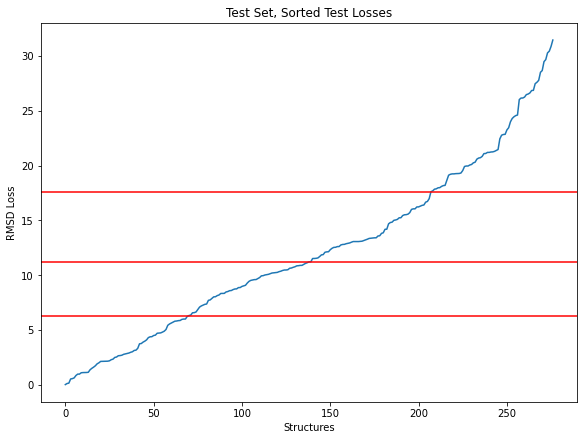

LinregressResult(slope=0.32567885296036964, intercept=9.483949251312799, rvalue=0.16902829305059403, pvalue=0.004790485005438878, stderr=0.11451686143367959, intercept_stderr=2.6842286190974707)


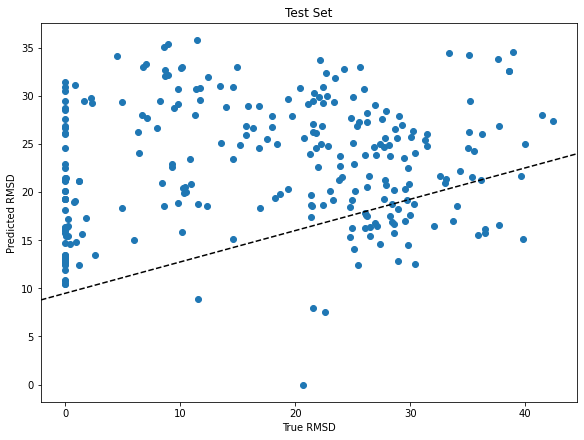

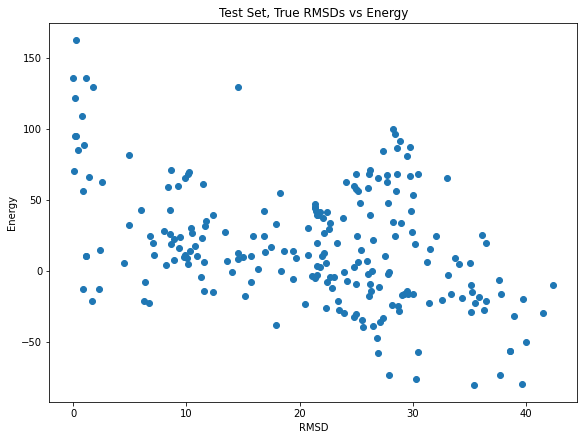

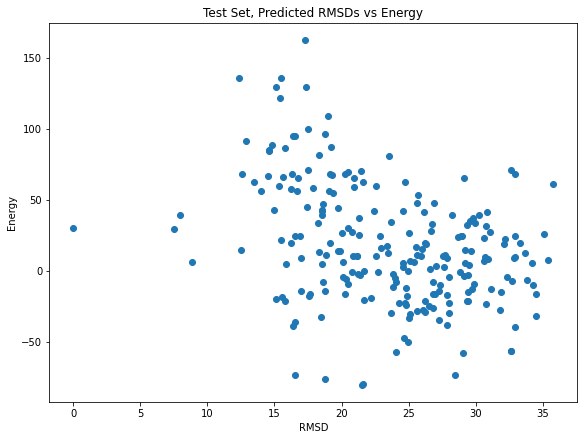

5S and tRNA Test Set
tensor([0.], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([0.], device='cuda:0') tensor([[33.5955]], device='cuda:0') 33.595489501953125
Mean Test loss: 	 5.3999
Std. Dev. of Test loss:  6.0524
Min loss: 		 0.0000
First Quantile: 	 1.5315
Median: 		 3.4353
Third Quantile: 	 6.4764
Max Loss: 		 33.5955


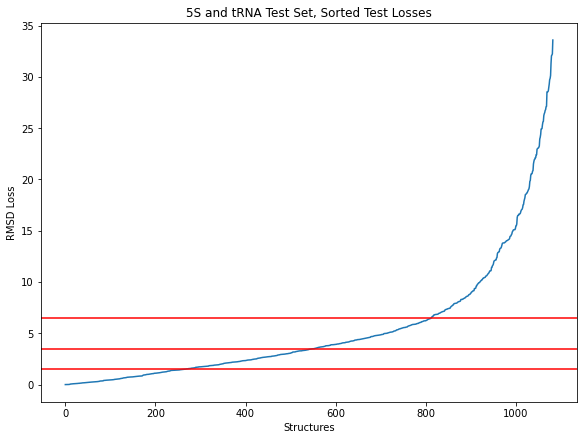

LinregressResult(slope=0.6770311809995766, intercept=3.6820797424266196, rvalue=0.547328804721312, pvalue=1.163543379578715e-85, stderr=0.03148692533241578, intercept_stderr=0.611688712521694)


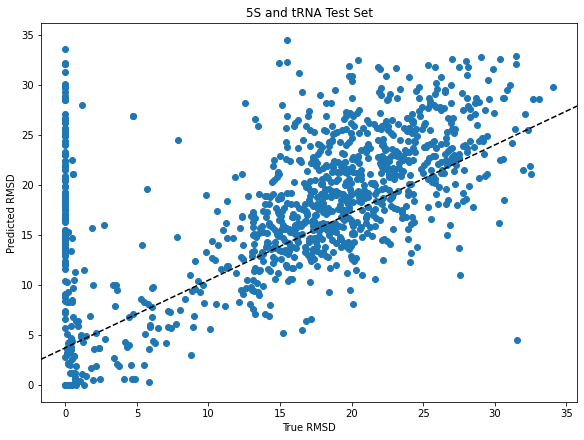

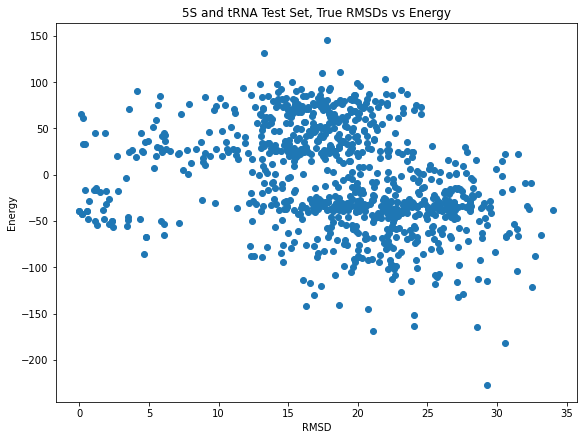

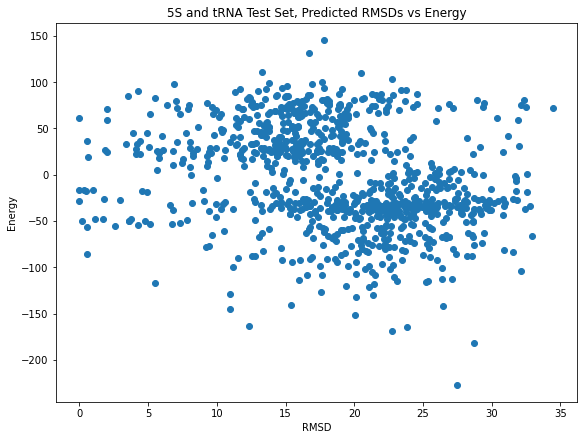

Training Set
tensor([0.], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([0.], device='cuda:0') tensor([[6.1061]], device='cuda:0') 6.106050968170166
Mean Test loss: 	 1.0227
Std. Dev. of Test loss:  0.6832
Min loss: 		 0.0000
First Quantile: 	 0.6043
Median: 		 0.9247
Third Quantile: 	 1.3052
Max Loss: 		 6.1061


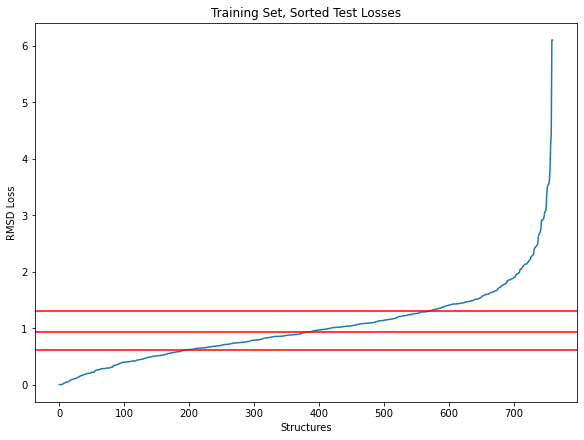

LinregressResult(slope=1.0143420847762379, intercept=0.6434980971850166, rvalue=0.9957903097995227, pvalue=0.0, stderr=0.0033912864064160626, intercept_stderr=0.06528533390969107)


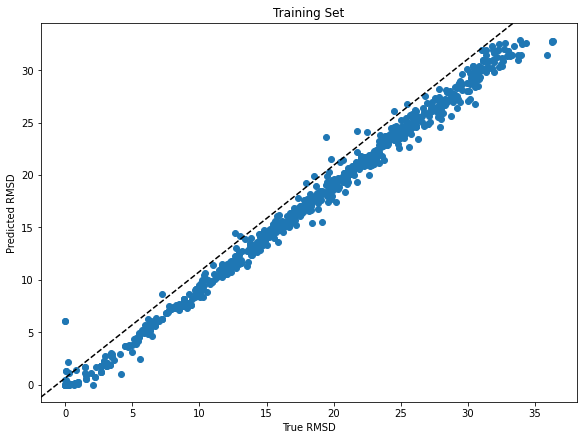

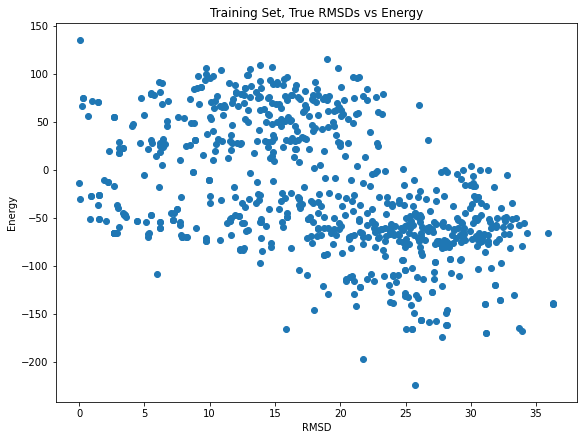

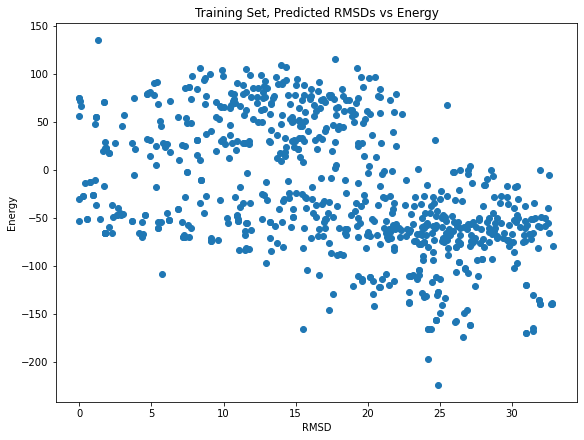

Validation Set
tensor([9.2090], device='cuda:0') tensor([[9.2156]], device='cuda:0') 0.006575584411621094
tensor([55.3040], device='cuda:0') tensor([[5.6384]], device='cuda:0') 49.665584564208984
Mean Test loss: 	 13.5881
Std. Dev. of Test loss:  9.8212
Min loss: 		 0.0066
First Quantile: 	 5.3895
Median: 		 11.9685
Third Quantile: 	 20.1162
Max Loss: 		 49.6656


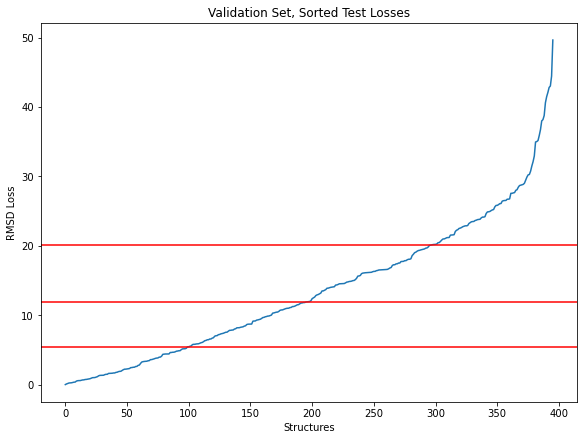

LinregressResult(slope=0.11132055639701927, intercept=20.76938073279983, rvalue=0.03753247023114651, pvalue=0.456399796854287, stderr=0.1493186313730137, intercept_stderr=3.41777261373681)


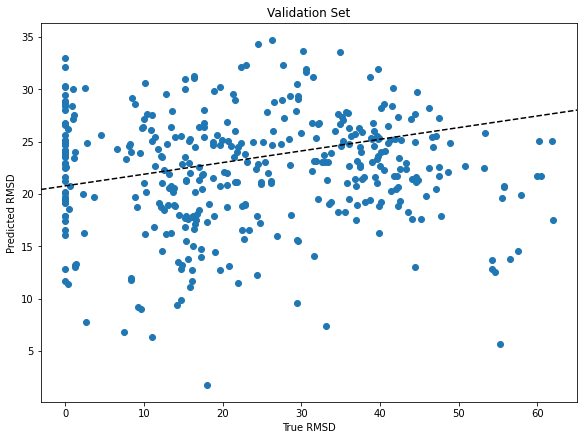

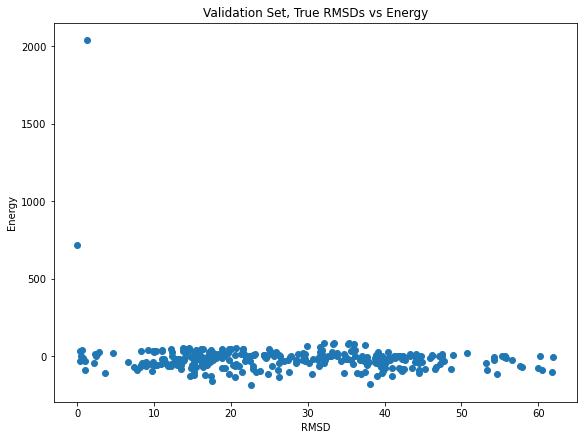

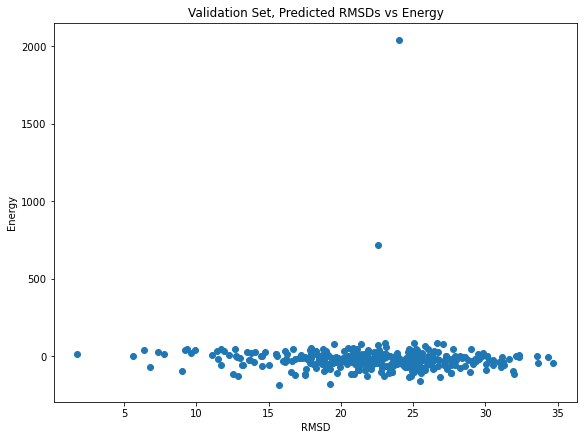

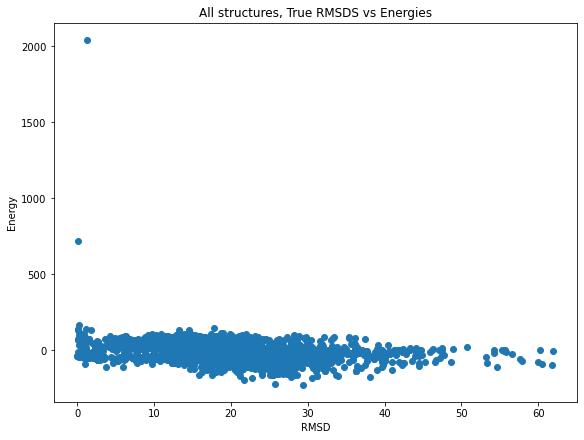

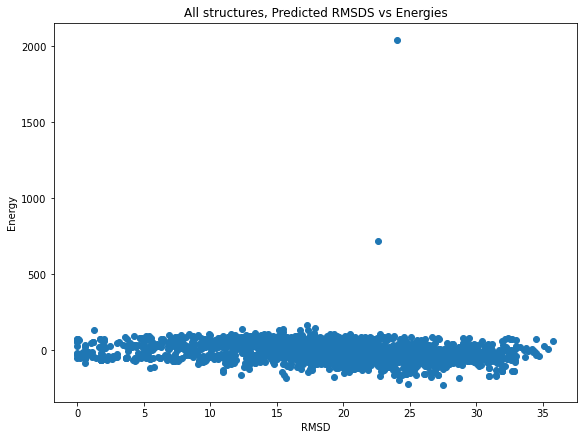

In [15]:
#Test
import math
from pyg_classifier.utility import get_energy_dict

if "model" not in globals():
    model = CG_Classifier(num_node_feats=training_dataset.num_node_features)

train_loader = DataLoader(training_dataset)
val_loader = DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)
st_test_dataloader = DataLoader(st_test_dataset)

model.to(device)
model.load_state_dict(th.load("pyg_model_data/model_epoch2050.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs = test_loop(model, loader, e_dict, title)
    energy_l += en
    true_rmsd_l += trs
    pred_rmsd_l += prs

e_rmsd_scatter(energy_l, true_rmsd_l, "All structures, True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures, Predicted RMSDS vs Energies")
        

In [12]:
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, num_neighbours)

LinregressResult(slope=0.1636735553842878, intercept=17.348640308399137, rvalue=0.17239615958669505, pvalue=0.004003996372601889, stderr=0.05639401620638288, intercept_stderr=1.3218527856750812)


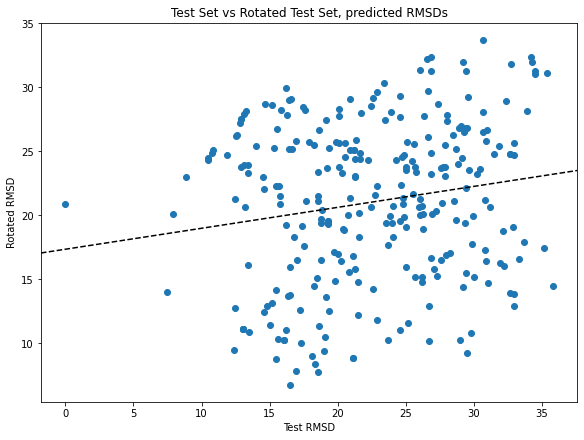

LinregressResult(slope=0.5507249841471382, intercept=3.8996752366306664, rvalue=0.5271046537901324, pvalue=3.2972411816328365e-21, stderr=0.0535412494753674, intercept_stderr=0.7462055492810632)


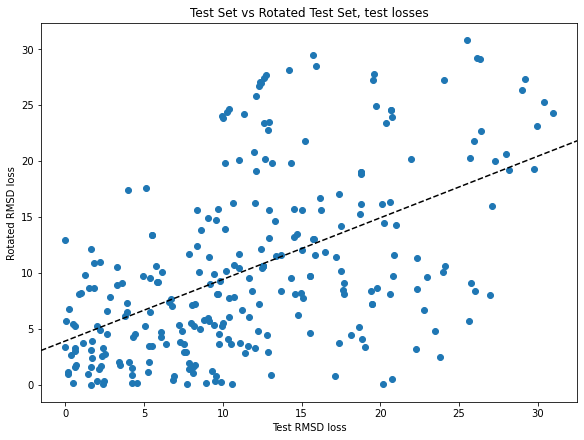

In [16]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset)

pred_dir = {}
loss_dir = {}
for loader in [test_dataloader, rot_test_dataloader]:
    with th.no_grad():
        model.eval()
        for test_graph in loader:
            test_graph = test_graph.to(device)
            test_pred = model(test_graph)
            test_loss = F.smooth_l1_loss(th.reshape(test_pred, (-1,)), test_graph.y).item()

            if test_graph.name[0] not in pred_dir.keys():
                pred_dir[test_graph.name[0]] = [float(test_pred)]
            else:
                pred_dir[test_graph.name[0]].append(float(test_pred))
            
            if test_graph.name[0] not in loss_dir.keys():
                loss_dir[test_graph.name[0]] = [float(test_loss)]
            else:
                loss_dir[test_graph.name[0]].append(float(test_loss))

test_preds = []
trot_preds = []
for a in pred_dir.keys():
    test_preds.append(pred_dir[a][0])
    trot_preds.append(pred_dir[a][1])

test_ls = []
trot_ls = []
for b in loss_dir.keys():
    test_ls.append(loss_dir[b][0])
    trot_ls.append(loss_dir[b][1])


reg = linregress(test_preds, trot_preds)
print(reg)

fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
plt.title("Test Set vs Rotated Test Set, predicted RMSDs")
axs1.scatter(test_preds, trot_preds)
axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
plt.xlabel("Test RMSD")
plt.ylabel("Rotated RMSD")
plt.show()

reg_l = linregress(test_ls, trot_ls)
print(reg_l)

fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
plt.title("Test Set vs Rotated Test Set, test losses")
axs2.scatter(test_ls, trot_ls)
axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
plt.xlabel("Test RMSD loss")
plt.ylabel("Rotated RMSD loss")
plt.show()
